In [1]:
import pandas as pd
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="dark")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _

In [2]:
df = pd.read_csv('ex1data1.txt', names = ['population', 'profit']) # 

In [3]:
df.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
population    97 non-null float64
profit        97 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB


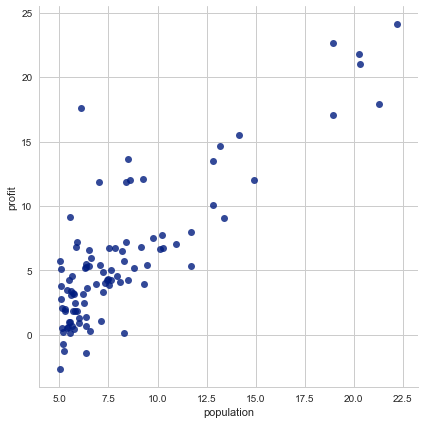

In [5]:
sns.lmplot('population', 'profit', df, size= 6, fit_reg = False)

In [9]:
# 读取特征
def get_X(df):
    """
    use concat to add intersect feature to avoid side effect
    not efficient for big dataset though
    """
    ones = pd.DataFrame({'ones':np.ones(len(df))})
    data = pd.concat([ones, df], axis = 1)
    return data.iloc[:, :-1].as_matrix()

# 读取标签
def get_y(df):
    """ assume the last column is the target"""
    return np.array(df.iloc[:, -1])

def normalize_feature(df):
    """ Applies function along input axis(default 0) of DataFrame."""
    # 特征缩放
    return df.apply(lambda column: (column - column.mean())/ column.std())
    
    
    
    

多变量的假设 h 表示为：\\[{{h}_{\theta }}\left( x \right)={{\theta }_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 
这个公式中有n+1个参数和n个变量，为了使得公式能够简化一些，引入${{x}_{0}}=1$，则公式转化为：  
此时模型中的参数是一个n+1维的向量，任何一个训练实例也都是n+1维的向量，特征矩阵X的维度是 m*(n+1)。 因此公式可以简化为：${{h}_{\theta }}\left( x \right)={{\theta }^{T}}X$，其中上标T代表矩阵转置。


In [17]:
def linear_regression(x_data, y_data, alpha, epoch, optimizer=tf.train.GradientDescentOptimizer):
    # placeholder for graph input
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    y = tf.placeholder(tf.float32, shape=y_data.shape)
    
    # construct the graph
    with tf.variable_scope('linear-regression'):
        W = tf.get_variable("weights",
                           (X_data.shape[1], 1),
                            initializer= tf.constant_initializer())
        y_pred = tf.matmul(X, W)
        
        loss = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True) 
      
    opt = optimizer(learing_rate = alpha)
    opt_operation = opt.miniize(loss)
    
    # run the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_data = []
        
        for i in range(epoch):
            _, loss_val, W_val = sess.run([opt_operation, loss, W], feed_dict = {X:X_Data, y:y_Data})
            loss_data.append(loss_val[0,0])
            
            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 100** -9:
                break
        
        tf.reset_default_graph()
        
        return {'loss': loss_data, 'parameters': W_val}

In [18]:
data = pd.read_csv('ex1data1.txt', names=['population', 'profit'])
data.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [19]:
X = get_X(data)
print(X.shape, type(X))

(97, 2) <class 'numpy.ndarray'>


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [21]:
y = get_y(data)
print(y.shape, type(y))

(97,) <class 'numpy.ndarray'>


In [22]:
theta = np.zeros(X.shape[1])

In [23]:
theta

array([0., 0.])

In [24]:
def lr_cost(theta, x, y):
    """
    X:R(m*n), m, 样本数, n特征数
    y:R(m)
    theta: R(n), 线性回归的参数
    """
    m = X.shape[0] # m为样本数
    inner = X @ theta - y # R(m*1), X@theta 等价于 X.dot(theta)
    
    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner
    cost = square_sum / (2 *m)
    
    return cost

In [25]:
lr_cost(theta, X, y)

32.07273387745567

# batch gradient decent（批量梯度下降）
$${{\theta }_{j}}:={{\theta }_{j}}-\alpha \frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right)$$

In [27]:
def gradient(theta, X, y):
    m = X.shape[0]
    
    inner = X.T @ (X @ theta - y)
    
    return inner/m


In [28]:
def batch_gradient_decent(theta, X, y, epoch, alpha = 0.01):
    """
    拟合线性回归, 返回参数和代价
    epoch: 批处理的轮数
    """
    
    cost_data = [lr_cost(theta, X, y)]
    _theta = theta.copy()
    
    for _ in range(epoch):
        _theta = _theta - alpha * gradient(_theta, X, y)
        cost_data.append(lr_cost(_theta, X, y))
        
    return _theta, cost_data

In [29]:
epoch = 500
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch)

In [30]:
final_theta

array([-2.28286727,  1.03099898])

In [31]:
cost_data

[32.07273387745567,
 6.737190464870012,
 5.931593568604956,
 5.901154707081388,
 5.895228586444221,
 5.89009494311733,
 5.885004158443644,
 5.879932480491418,
 5.874879094762573,
 5.869843911806388,
 5.8648268653129305,
 5.8598278899321805,
 5.85484692057229,
 5.849883892376588,
 5.844938740722034,
 5.8400114012183595,
 5.8351018097072265,
 5.830209902261388,
 5.825335615183862,
 5.820478885007098,
 5.815639648492154,
 5.810817842627869,
 5.806013404630045,
 5.801226271940628,
 5.796456382226899,
 5.791703673380653,
 5.7869680835173956,
 5.782249550975539,
 5.777548014315596,
 5.772863412319381,
 5.768195683989214,
 5.76354476854712,
 5.758910605434049,
 5.7542931343090755,
 5.749692295048627,
 5.745108027745684,
 5.740540272709012,
 5.735988970462381,
 5.731454061743792,
 5.726935487504702,
 5.722433188909257,
 5.717947107333528,
 5.713477184364749,
 5.709023361800549,
 5.704585581648199,
 5.700163786123856,
 5.6957579176518145,
 5.691367918863751,
 5.68699373259798,
 5.68263530189870

In [32]:
theta

array([0., 0.])

In [33]:
# 计算最终的代价
lr_cost(final_theta, X, y)

4.7138095311168655

## visualize cost data（代价数据可视化）

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


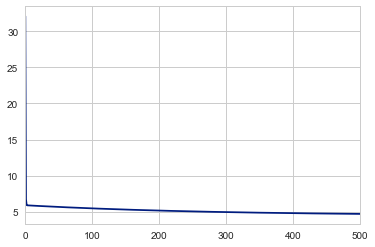

In [35]:
ax = sns.tsplot(cost_data, time = np.arange(epoch+1))

In [36]:
ax.set_xlabel("epoch")

Text(0.5,3.2,'epoch')

In [37]:
ax.set_ylabel("cost")

Text(3.2,0.5,'cost')

In [39]:
plt.show()

In [40]:
b = final_theta[0]

In [41]:
b

-2.2828672749589267

In [42]:
m = final_theta[1]
m

1.0309989777517024

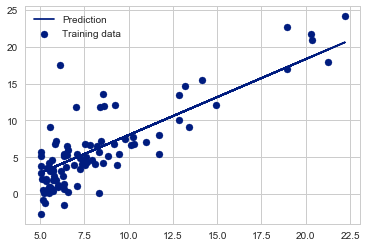

In [51]:
plt.scatter(data.population, data.profit, label="Training data")
plt.plot(data.population, data.population*m + b, label = "Prediction")
plt.legend(loc=2)
plt.show()